
# **<center><font style="color:rgb(100,109,254)">Human Action Recognition in Videos</font> </center>**

### **<font style="color:rgb(134,19,348)"> Import drive</font>**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

In [ ]:
# Discard the output of this cell.
%%capture

# Install the required libraries.
!pip install youtube-dl moviepy
!pip install git+https://github.com/TahaAnwar/pafy.git

In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **<font style="color:rgb(134,19,348)">Step 1: Download and Extract the Data with its Labels</font>**




In [ ]:
# Discard the output of this cell.
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate "/content/drive/MyDrive/Colab Notebooks/Image_Processing/Video_Dataset.rar"

#Extract the Dataset
!unrar x Video_Dataset.rar

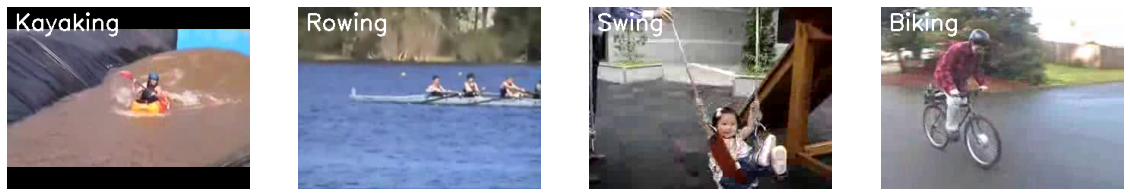

In [ ]:
plt.figure(figsize = (20, 20))
all_classes_names = os.listdir('Video_Dataset')
random_range = random.sample(range(len(all_classes_names)), 4)

for counter, random_index in enumerate(random_range, 1):

    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'Video_Dataset/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'Video_Dataset/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**


### **<font style="color:rgb(134,19,348)">Create a Function to Extract, Resize & Normalize Frames</font>**

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20 
DATASET_DIR = "Video_Dataset"
CLASSES_LIST = ["Biking", "Rowing", "Swing", "Kayaking"]

def frames_extraction(video_path):

    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**

In [ ]:
def create_dataset():

    dataset = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                dataset.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    dataset = np.asarray(dataset)
    labels = np.array(labels)  

    return dataset, labels, video_files_paths

In [ ]:
# Create the dataset.
dataset, labels, video_files_paths = create_dataset()

Extracting Data of Class: Biking
Extracting Data of Class: Rowing
Extracting Data of Class: Swing
Extracting Data of Class: Kayaking


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
one_hot_encoded_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

## **<font style="color:rgb(134,19,348)">Step 3: Split the Data into Train and Test Set</font>**

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
data_train, data_test, labels_train, labels_test = train_test_split(dataset, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

## **<font style="color:rgb(134,19,348)">Step 4: Implement the Long-term Recurrent Convolutional Network (LRCN) Approach</font>**

### **<font style="color:rgb(134,19,348)">Step 4.1: Construct the Model</font>**

In [ ]:
def create_LRCN_model():

    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()
    return model

In [ ]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 20, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 20, 4, 4, 32)    

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**


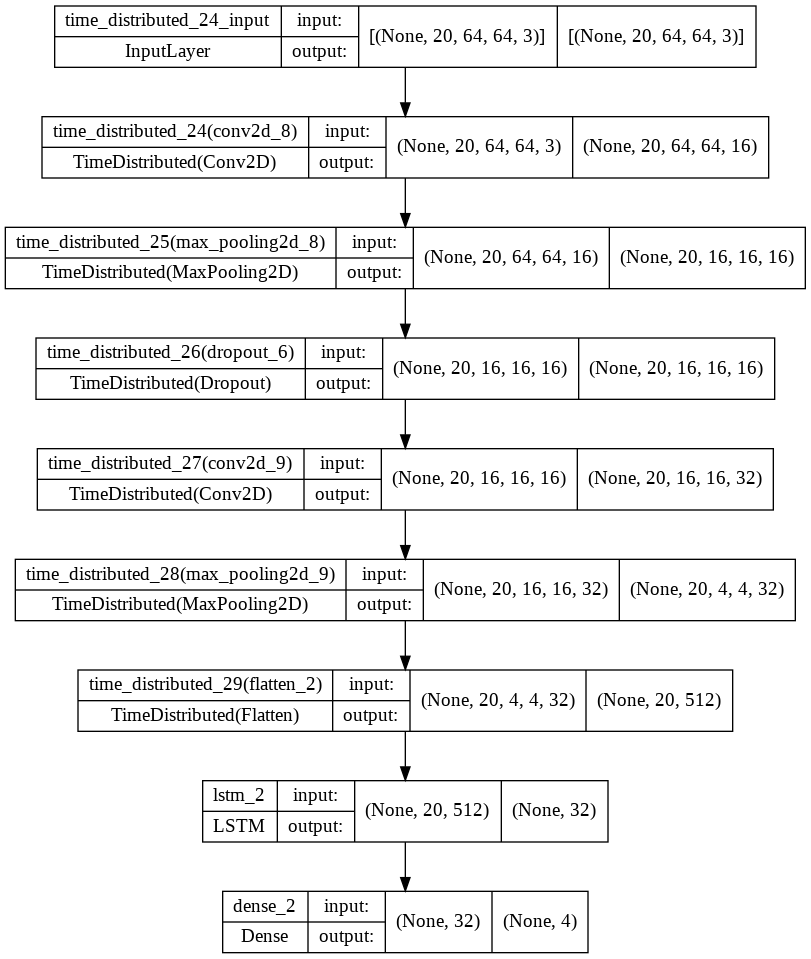

In [ ]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 5.2: Compile, Training & Save the Model</font>**


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath="/content/drive/MyDrive/Model/Image1.h5"

# Create an Instance of Early Stopping Callback.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200, restore_best_weights = True)
checkpointer = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training and save the model.
LRCN_model_training_history = LRCN_model.fit(data_train, labels_train, epochs = 40, batch_size = 32 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [es, checkpointer])

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 1.4121 - accuracy: 0.2812
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /content/drive/MyDrive/Model/Image1.h5
11/11 [==============================] - 17s 1s/step - loss: 1.4121 - accuracy: 0.2812 - val_loss: 1.3376 - val_accuracy: 0.3333
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 1.2909 - accuracy: 0.4232
Epoch 2: val_accuracy improved from 0.33333 to 0.35632, saving model to /content/drive/MyDrive/Model/Image1.h5
11/11 [==============================] - 14s 1s/step - loss: 1.2909 - accuracy: 0.4232 - val_loss: 1.2882 - val_accuracy: 0.3563
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 1.1919 - accuracy: 0.4667
Epoch 3: val_accuracy improved from 0.35632 to 0.48276, saving model to /content/drive/MyDrive/Model/Image1.h5
11/11 [==============================] - 14s 1s/step - loss: 1.1919 - accuracy: 0.4667 - val_loss: 1.1794 - val_accuracy: 0.4828
E

In [ ]:
print("Train score:", LRCN_model.evaluate(data_train,labels_train))

14/14 [==============================] - 6s 398ms/step - loss: 0.2934 - accuracy: 0.9236
Train score: [0.29335343837738037, 0.9236111044883728]


#### **<font style="color:rgb(134,19,348)">Load the trained Model</font>**

In [ ]:
from tensorflow.keras.models import load_model
LRCN_model = load_model("/content/drive/MyDrive/Model/Image1.h5")

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(data_test, labels_test)

5/5 [==============================] - 3s 377ms/step - loss: 0.5696 - accuracy: 0.8125


### **<font style="color:rgb(134,19,348)">Create a Function to Download YouTube Videos:</font>**

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):

     video = pafy.new(youtube_video_url)
     title = video.title
     video_best = video.getbest()
 
     output_file_path = f'{output_directory}/{title}.mp4'
     video_best.download(filepath = output_file_path, quiet = True)
     
     return title

### **<font style="color:rgb(134,19,348)">Download a Test Video:</font>**

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
#Swing: https://www.youtube.com/watch?v=itq9fBuKkXs
#Biking: https://www.youtube.com/watch?v=9INixja2eNQ

video_title = download_youtube_videos('https://www.youtube.com/watch?v=9INixja2eNQ', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

### **<font style="color:rgb(134,19,348)">Create a Function To Perform Action Recognition on Videos</font>**

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
    predicted_class_name = ''
    while video_reader.isOpened():

        ok, frame = video_reader.read() 

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        video_writer.write(frame)
    video_reader.release()
    video_writer.release()

### **<font style="color:rgb(134,19,348)">Perform Action Recognition on the Test Video</font>**

In [ ]:
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

 94%|█████████▍| 227/241 [00:00<00:00, 329.15it/s]WARNING:py.warnings:/usr/local/lib/python3.7/dist-packages/moviepy/video/io/ffmpeg_reader.py:130: UserWarning: Warning: in file test_videos/v Biking g02 c02-Output-SeqLen20.mp4, 360000 bytes wanted but 0 bytes read,at frame 240/241, at time 8.01/8.01 sec. Using the last valid frame instead.
  UserWarning)

100%|██████████| 241/241 [00:00<00:00, 313.62it/s]
